## CellMincer segmentation

The loss function is:

$$\mathcal{L} = \sum_p \left|M_{tp} - \textstyle{\sum_{\mu=1}^{N_{\mathrm{max}}}} \alpha_p \, \alpha_{\mu} \, \omega_{\mu p} \, \tau_{\mu t}\right|^2 + \mathcal{L}_\mathrm{reg}$$
$$\mathcal{L}_\mathrm{reg} = \lambda_\mathrm{loc} \, \sum_{\mu=1}^{N_{\mathrm{max}}} \, \gamma_\mu[\omega_{\mu p}] +
\lambda_\mathrm{ent} \, \mathbb{H}[\Omega_\mu].$$

Here, $p$, $\mu$, and $t$ correspond to pixels, objects (neurons), and time, respectively. $\alpha_p \in [0, 1]$ is the per-pixel foreground contribution, $\alpha_{\mu} \in [0, 1]$ is the global responsibility of each object, $\omega_{\mu p} \in \mathrm{Simplex}^{N_{\mathrm{max}}}$ is the per-pixel responsibility of each object, and $\tau_{\mu t}$ is the temporal trace of each neuron.

There are two regularization terms: one enforcing locality of each object and another enforcing the parsimony of factorization. $\gamma_\mu[\omega_{\mu p}]$ is defined as:

$$\gamma_\mu[\omega_{\mu p}] \equiv 1 - \frac{\max_p\, \sum_{p'} \left(\theta[d(p, p') - r^*] \, \omega_{\mu p'}\right)} {\sum_{p'} \omega_{\mu p'}}$$.

Intuitively, calculating $\gamma_\mu[\omega_{\mu p}]$ involves finding a circular region of radius $r^*$ that contains most of the weight, and then calculating what fraction of the weight lies outside of this region. Calculating $\gamma_\mu[\omega_{\mu p}]$ is very fast and easy using 2D convolutions with a circular kernel.

The second regularization seeks to explain the movie with as few objects as possible. $\Omega_{\mu}$ is defined as:

$$\Omega_{\mu} \equiv \frac{\sum_p \alpha_p \, \alpha_{\mu} \, \omega_{\mu p}}{\sum_{\mu, p} \alpha_p \, \alpha_{\mu} \, \omega_{\mu p}}$$,

and denotes the global responsibility of object $\mu$. By minimizing the entropy of this (empirical) distribution, we encourage decreasing $\alpha_{\mu}$ of unncessary objects. Note: we must experiment with detaching various terms in this regularization.

Finally, $\omega_{\mu p}$ is calculated as follows. We define:

$$\chi_{\mu p} \equiv \frac{\frac{1}{N_T}\sum_{t=1}^{N_t}\left(M_{tp} - \bar{M}_{tp}\right)\left(\tau_{\mu t} - \bar{\tau}_{\mu t}\right)}{\sigma(M_{tp} - \bar{M}_{tp}) \, \sigma(\tau_{\mu t} - \bar{\tau}_{\mu t})}$$,

where $\bar{M}_{tp}$ and $\bar{\tau}_{\mu t}$ denote the movie and trace trends, respectively (calculated via moving average or median filtering). Intuitively, $\chi_{\mu p} \in [-1, 1]$ is positive and large for pixels that temporally correlated with $\tau_{\mu t}$. We feed $\chi_{\mu p}$ to a U-Net conditioned on global features $\mathfrak{F}$, and expected a probability map $\tilde{\omega}_{\mu p} \in [0, 1]$ in the output. The latter denotes the responsibility of each pixel for trace element $\mu$. Finally, we lift the single-trace probability maps to a simplex:

$$\omega_{\mu p} \equiv \frac{\tilde{\omega}_{\mu p}}{\sum_\mu \tilde{\omega}_{\mu p}}$$.

The global per-pixel responsibility $\alpha_p$ is calculated from $\mathfrak{F}$ via a dedicated U-Net. $\{\alpha_\mu\}$ are variational parameters. The training involves a E-step and an M-step. In the E-step, $\tau_{\mu t}$ are help fixed and everything else is optimized. In the M-step, everything is fixed save for $\tau_{\mu t}$. We perform inexact E- and M-step updates via SGD. We initiatize $\tau_{\mu t}$ to a uniform subsampling of foreground pixels.

In [3]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import torch
import logging
import pickle

from skimage.filters import threshold_otsu

from cellmincer.opto_ws import \
    OptopatchBaseWorkspace, \
    OptopatchGlobalFeaturesTorchCache

from cellmincer.opto_features import \
    OptopatchGlobalFeatureExtractor, \
    OptopatchGlobalFeatureContainer

from cellmincer.opto_denoise import \
    get_unet_input_size

from cellmincer.opto_models import \
    ConditionalUNet, \
    center_crop_2d, \
    activation_from_str

from cellmincer.opto_utils import \
    crop_center

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()
log_info = logger.warning

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [4]:
# list of Optopatch movies
model_prefix = 'final_nopad_l2'

denoised_opto_mov_path_list = [
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D1_FOV3_W2_at135105__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D4_FOV2_W2_at171603__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D4_FOV3_W2_at172029__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/E3_FOV1_W2_at155440__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/F1_FOV2_W1_at143005__{model_prefix}__denoised.npy',
]

denoised_opto_feature_path_list = [
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/D1_FOV3_W2_at135105__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/D4_FOV2_W2_at171603__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/D4_FOV3_W2_at172029__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/E3_FOV1_W2_at155440__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/F1_FOV2_W1_at143005__features.pkl',
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

# output
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data'
feature_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/feature_data'
model_root = '/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models_new'

if not os.path.exists(feature_path):
    os.mkdir(feature_path)

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
if not os.path.exists(model_root):
    os.mkdir(model_root)

In [5]:
i_dataset = 0
ws_base = OptopatchBaseWorkspace.from_npy(denoised_opto_mov_path_list[i_dataset])
with open(denoised_opto_feature_path_list[i_dataset], 'rb') as f:
    feature_container = pickle.Unpickler(f).load()

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D1_FOV3_W2_at135105__final_nopad_l2__denoised.npy ...


In [6]:
active_mask_t = OptopatchGlobalFeatureExtractor.determine_active_t_range(
    ws_base=ws_base,
    select_active_t_range=True)

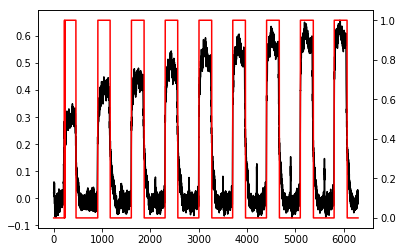

In [7]:
fig = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(np.mean(ws_base.movie_txy, axis=(-1, -2)), color='black')
ax2.plot(active_mask_t, color='red')

In [8]:
ws_base = ws_base.get_t_truncated_movie(np.where(active_mask_t)[0][:500])

In [9]:
# if segmenter_config['unet_padding']:
#     _unet_kernel_size = 1
# else:
#     _unet_kernel_size = segmenter_config['unet_kernel_size']
    
# unet_width = get_unet_input_size(
#     output_min_size=ws_base.width,
#     kernel_size=_unet_kernel_size,
#     n_conv_layers=segmenter_config['unet_n_conv_layers'],
#     depth=segmenter_config['unet_depth'])

# unet_height = get_unet_input_size(
#     output_min_size=ws_base.height,
#     kernel_size=_unet_kernel_size,
#     n_conv_layers=segmenter_config['unet_n_conv_layers'],
#     depth=segmenter_config['unet_depth'])

# x_padding = (unet_width - ws_base.width) // 2
# y_padding = (unet_height - ws_base.height) // 2

# print(f'x-padding: {x_padding}px')
# print(f'y-padding: {y_padding}px')

x_padding = 0
y_padding = 0

In [10]:
viz_pix_list = [
    (20, 62),
    (125, 80),
    (165, 150),
    (200, 150),
    (180, 120),
    (395, 135),
    (400, 150),
]

## Implementation

In [11]:
# def get_gaussian_lowpass_kernel(scale: float, rep: int):
#     length = int(np.ceil(rep * scale))
#     if length % 2 == 0:
#         length += 1
#     x = np.arange(0, length)
#     x -= x[(length - 1) // 2]
#     gaussian = np.exp(- np.power(x, 2) / (2 * scale ** 2))
#     return gaussian / np.sum(gaussian)

# # temporal gaussian low-pass
# glp_scale = 0.1
# glp_rep = 5 
# glp_kernel = get_gaussian_lowpass_kernel(glp_scale, glp_rep)
# detrended_movie_n1t = detrended_movie_txy.view(padded_movie.original_n_frames, -1).permute(-1, -2)[:, None, :]
# glp_detrended_movie_n1t = torch.nn.functional.conv1d(
#     detrended_movie_n1t,
#     weight=torch.tensor(glp_kernel[None, None, :], device=device, dtype=dtype),
#     padding=(len(glp_kernel) - 1)//2)
# glp_detrended_movie_txy = glp_detrended_movie_n1t[:, 0, :].permute(-1, -2).view(
#     padded_movie.original_n_frames, padded_movie.original_width, padded_movie.original_height)

# detrended_unpad_movie_txy = detrended_movie_txy[
#     :,
#     x_padding:(x_padding + original_width),
#     y_padding:(y_padding + original_height)]

# glp_detrended_unpad_movie_txy = glp_detrended_movie_txy[
#     :,
#     x_padding:(x_padding + original_width),
#     y_padding:(y_padding + original_height)]

In [12]:
def get_detrended_movie_torch(
        movie_ntxy: np.ndarray,
        detrending_order: int,
        detrending_func: str,
        device: torch.device,
        dtype: torch.dtype) -> torch.Tensor:
    assert detrending_order > 0
    assert detrending_func in {'mean', 'median'}
    
    # reflection pad in time
    padded_movie_ntxy = torch.tensor(
        np.pad(
            array=movie_ntxy,
            pad_width=((0, 0), (detrending_order, detrending_order), (0, 0), (0, 0)),
            mode='reflect'),
        device=device,
        dtype=dtype)
    
    detrended_movie_ntxy = torch.zeros(
        movie_ntxy.shape,
        device=device,
        dtype=dtype)

    # calculate temporal moving average
    if detrending_func == 'mean':
        for i_t in range(movie_ntxy.shape[-3]):
            detrended_movie_ntxy[:, i_t, :, :] = padded_movie_ntxy[:, i_t + detrending_order, :, :] - torch.mean(
                padded_movie_ntxy[:, i_t:(i_t + 2 * detrending_order + 1), :, :],
                dim=-3)
    elif detrending_func == 'median':
        for i_t in range(movie_ntxy.shape[-3]):
            detrended_movie_ntxy[:, i_t, :, :] = padded_movie_ntxy[:, i_t + detrending_order, :, :] - torch.median(
                padded_movie_ntxy[:, i_t:(i_t + 2 * detrending_order + 1), :, :],
                dim=-3)[0]
    else:
        raise ValueError()

    return detrended_movie_ntxy


def get_detrended_tau_mt(
        tau_mt: torch.Tensor,
        detrending_order: int,
        detrending_func: str,
        device: torch.device,
        dtype: torch.dtype) -> torch.Tensor:
    assert detrending_order > 0
    assert detrending_func in {'mean'}
    
    # reflection pad in time
    padded_tau_m1t = torch.nn.ReflectionPad1d(detrending_order)(
        tau_mt[:, None, :])
    
    # trend
    moving_average_kern = torch.ones(
        (1, 1, 2 * detrending_order + 1),
        device=device,
        dtype=dtype) / (2 * detrending_order + 1)
    padded_tau_trend_m1t = torch.nn.functional.conv1d(
        padded_tau_m1t, moving_average_kern)
    return tau_mt - padded_tau_trend_m1t[:, 0, ]


class OptopatchSegmentationWorkspace:
    def __init__(
            self,
            ws_base: OptopatchBaseWorkspace,
            features: OptopatchGlobalFeatureContainer,
            x_padding: int,
            y_padding: int,
            detrending_order: int,
            detrending_func: str,
            eps: float,
            device: torch.device,
            dtype: torch.dtype):
        self.ws_base = ws_base
        self.features = features
        self.x_padding = x_padding
        self.y_padding = y_padding        
        self.detrending_order = detrending_order
        self.detrending_func = detrending_func
        self.eps = eps
        self.device = device
        self.dtype = dtype

        self.padded_width = ws_base.width + 2 * x_padding
        self.padded_height = ws_base.height + 2 * y_padding
        
        # pad and cache the features
        self.cached_features = OptopatchGlobalFeaturesTorchCache(
            features=features,
            x_padding=x_padding,
            y_padding=y_padding,
            device=device,
            dtype=dtype)
        
        # pad the scaled movie
        padded_movie_1txy = np.pad(
            array=ws_base.movie_txy / features.norm_scale,
            pad_width=((0, 0), (x_padding, x_padding), (y_padding, y_padding)),
            mode='reflect')[None, ...]

        # detrend the scaled movie
        self.padded_detrended_movie_1txy = get_detrended_movie_torch(
            movie_ntxy=padded_movie_1txy,
            detrending_order=detrending_order,
            detrending_func=detrending_func,
            device=device,
            dtype=dtype)
        
        self.padded_movie_1txy = torch.tensor(
            padded_movie_1txy,
            device=device, dtype=dtype)
        
        # detrended movie std
        self.padded_detrended_movie_std_1xy = self.padded_detrended_movie_1txy.std(dim=-3)

    def get_chi_mxy(
            self,
            tau_mt: torch.Tensor,
            t_begin_index: int,
            t_end_index: int) -> torch.Tensor:
        
        # slice to the specified time windows
        tau_mt = tau_mt[:, t_begin_index:t_end_index]
        
        # detrend tau
        detrended_tau_mt = get_detrended_tau_mt(
            tau_mt=tau_mt,
            detrending_order=self.detrending_order,
            detrending_func=self.detrending_func,
            device=self.device,
            dtype=self.dtype)
        
        padded_detrended_movie_1txy = self.padded_detrended_movie_1txy[
            :, t_begin_index:t_end_index, :, :]
        detrended_movie_std_1xy = padded_detrended_movie_1txy.std(-3)
        detrended_tau_std_m = detrended_tau_mt.std(-1)

        inner_mxy = torch.mean(
            detrended_tau_mt[:, :, None, None] * padded_detrended_movie_1txy,
            dim=-3)
        
        detrended_cross_correlation_mxy = inner_mxy / (
            self.eps + detrended_tau_std_m[:, None, None] * detrended_movie_std_1xy)
        
        return detrended_cross_correlation_mxy
    

def get_delocalization_score(weight_ncxy: torch.Tensor, radius: int, eps: float = 1e-6):
    device = weight_ncxy.device
    dtype = weight_ncxy.dtype
    
    # circular structure
    x = torch.arange(-radius, radius + 1, dtype=dtype, device=device)[None, :]
    y = torch.arange(-radius, radius + 1, dtype=dtype, device=device)[:, None]
    struct = ((x.pow(2) + y.pow(2)) <= (radius ** 2)).type(dtype)
    kern = struct[None, None, ...]
    
    # calculate locally-summed weight
    padded_weight_ncxy = torch.nn.ZeroPad2d(radius)(weight_ncxy)
    locally_summed_weight_map_ncxy = center_crop_2d(
        layer=torch.nn.functional.conv2d(padded_weight_ncxy, kern),
        target=weight_ncxy)
    
    # total weight
    total_weight_nc = torch.sum(weight_ncxy, dim=(-1, -2))
    
    # largest locally summed weight
    max_weight_nc, _ = torch.max(locally_summed_weight_map_ncxy.view(
        locally_summed_weight_map_ncxy.shape[0],
        locally_summed_weight_map_ncxy.shape[1],
        -1), dim=-1)
    
    return 1. - max_weight_nc / (total_weight_nc + eps)

def get_loss(
        ws_base: OptopatchBaseWorkspace,
        ws_seg: OptopatchSegmentationWorkspace,
        segmenter_config: dict,
        pixel_fg_weight_net: torch.nn.Module,
        pixel_neuron_weight_net: torch.nn.Module,
        tau_mt: torch.nn.Parameter,
        logit_alpha_tau_m: torch.nn.Parameter,
        t_begin_index: int,
        t_end_index: int,
        eps: float = 1e-6) -> torch.Tensor:
    
    # auxiliary variables
    dict_size = segmenter_config['trace_dict_size']
    alpha_tau_m = torch.sigmoid(logit_alpha_tau_m)
    
    # calculate chi_mxy
    chi_mxy = ws_seg.get_chi_mxy(
        tau_mt=tau_mt,
        t_begin_index=t_begin_index,
        t_end_index=t_end_index)
    
    # calculate omega_mxy
    pixel_weight_net_output_dict = pixel_neuron_weight_net(
        chi_mxy[:, None, :, :],
        ws_seg.cached_features.features_1fxy.expand(
            (dict_size,) + ws_seg.cached_features.features_1fxy.shape[1:]))
#     pixel_weight_net_output_dict = pixel_neuron_weight_net(
#         chi_mxy[:, None, :, :])
    omega_tilde_mxy = pixel_weight_net_output_dict['readout_n1xy'][:, 0, :, :]
    omega_mxy = omega_tilde_mxy / (omega_tilde_mxy.sum(0, keepdim=True) + eps)
    omega_mxy = crop_center(
        omega_mxy,
        target_width=ws_base.width,
        target_height=ws_base.height)
    
    # calculate alpha_fg_xy
    pixel_fg_weight_net_output = pixel_fg_weight_net(ws_seg.cached_features.features_1fxy)
    alpha_fg_xy = pixel_fg_weight_net_output['readout_n1xy'][0, 0, :, :]
    alpha_fg_xy = crop_center(
        alpha_fg_xy,
        target_width=ws_base.width,
        target_height=ws_base.height)
    
    # calculate global trace dicionary element responsibility
    big_omega_m = torch.einsum(
        'm,xy,mxy->m',
        alpha_tau_m,
        alpha_fg_xy.detach(),
        omega_mxy.detach())
    big_omega_m = big_omega_m / (big_omega_m.sum() + eps)

    # calculate the dictionary element usage entropy
    omega_entropy = torch.sum(big_omega_m * (big_omega_m + eps).log())
    entropy_loss = - segmenter_config['entropy_penalty_strength'] * omega_entropy
    
    # calculate delocalization
    delocaliation_m = get_delocalization_score(
        omega_mxy[:, None, :, :],
        radius=segmenter_config['neuron_radius'])[:, 0]
    delocalization_loss = segmenter_config['delocalization_penalty_strength'] * \
        torch.sum(delocaliation_m * alpha_tau_m)
    
    # calculate reconstruction loss
    expected_movie_txy = crop_center(
        ws_seg.padded_movie_1txy[0, t_begin_index:t_end_index, :, :],
        target_width=ws_base.width,
        target_height=ws_base.height)
    reconstructed_movie_txy = torch.einsum(
        'm,xy,mxy,mt->txy',
        alpha_tau_m,
        alpha_fg_xy,
        omega_mxy,
        tau_mt[:, t_begin_index:t_end_index])
    rec_loss = torch.mean((expected_movie_txy - reconstructed_movie_txy).pow(2))

    # inducing loss for the mask
    with torch.no_grad():
        omega_inducing_mxy = torch.clamp(chi_mxy, min=eps)
        omega_inducing_mxy = omega_inducing_mxy / (omega_inducing_mxy.sum(0, keepdim=True) + eps)
        
    omega_inducing_loss = segmenter_config['omega_induction_strength'] \
        * torch.mean((omega_mxy - omega_inducing_mxy).pow(2))

    return {
        'rec_loss': rec_loss,
        'entropy_loss': entropy_loss,
        'delocalization_loss': delocalization_loss,
        'omega_inducing_loss': omega_inducing_loss,
        'alpha_fg_xy': alpha_fg_xy,
        'omega_mxy': omega_mxy,
        'chi_mxy': chi_mxy,
        'omega_inducing_mxy': omega_inducing_mxy
    }

## Initialization

In [13]:
segmenter_config = {
    'trace_dict_size': 20,
    'neuron_radius': 50,
    'entropy_penalty_strength': 0.05,
    'delocalization_penalty_strength': 0.05,
    'omega_induction_strength': 5.0,
    'detrending_order': 5,
    'detrending_func': 'mean',
    'unet_kernel_size': 3,
    'unet_n_conv_layers': 2,
    'unet_depth': 2,
    'unet_wf': 3,
    'unet_padding': True
}

In [14]:
ws_seg = OptopatchSegmentationWorkspace(
    ws_base=ws_base,
    features=feature_container,
    x_padding=x_padding,
    y_padding=y_padding,
    detrending_order=segmenter_config['detrending_order'],
    detrending_func=segmenter_config['detrending_func'],
    eps=1e-6,
    device=device,
    dtype=dtype)


# initialize the trace dictionary
trend_std_xy = crop_center(
    ws_seg.cached_features.features_1fxy[
        0, ws_seg.cached_features.feature_name_list.index('trend_std_0'), :, :],
    target_width=ws_base.width,
    target_height=ws_base.height).cpu().numpy()

fg_threshold = threshold_otsu(trend_std_xy)
fg_mask_xy = trend_std_xy > fg_threshold
fg_pixel_indices = np.where(fg_mask_xy)
n_fg_pixels = len(fg_pixel_indices[0])
assert n_fg_pixels > 0
random_fg_pixel_indices = np.random.choice(
    np.arange(n_fg_pixels),
    replace=False,
    size=segmenter_config['trace_dict_size'])
fg_x_indices = fg_pixel_indices[0][random_fg_pixel_indices]
fg_y_indices = fg_pixel_indices[1][random_fg_pixel_indices]

tau_mt = torch.nn.Parameter(
    torch.tensor(
        ws_base.movie_txy[:, fg_x_indices, fg_y_indices].T,
        device=device,
        dtype=dtype))

# initialize trace dictionary responsibility
logit_alpha_tau_m = torch.nn.Parameter(
    torch.zeros(
        segmenter_config['trace_dict_size'],
        device=device, dtype=dtype))

pixel_neuron_weight_net = ConditionalUNet(
    in_channels=1,
    out_channels=1,
    data_dim=2,
    feature_channels=ws_seg.cached_features.features_1fxy.shape[-3],
    depth=segmenter_config['unet_depth'],
    wf=segmenter_config['unet_wf'],
    out_channels_before_readout=2 ** segmenter_config['unet_wf'],
    final_trans=torch.nn.Sigmoid(),
    pad=segmenter_config['unet_padding'],
    batch_norm=False,
    unet_kernel_size=segmenter_config['unet_kernel_size'],
    n_conv_layers=segmenter_config['unet_n_conv_layers'], 
    readout_hidden_layer_channels_list=[],
    readout_kernel_size=1,
    activation=torch.nn.ReLU(),
    device=device,
    dtype=dtype)


# pixel_neuron_weight_net = ConditionalUNet(
#     in_channels=1,
#     out_channels=1,
#     data_dim=2,
#     feature_channels=0,
#     depth=1,
#     wf=2,
#     out_channels_before_readout=4,
#     final_trans=torch.nn.Sigmoid(),
#     pad=segmenter_config['unet_padding'],
#     batch_norm=False,
#     unet_kernel_size=segmenter_config['unet_kernel_size'],
#     n_conv_layers=segmenter_config['unet_n_conv_layers'], 
#     readout_hidden_layer_channels_list=[4, 4],
#     readout_kernel_size=1,
#     activation=torch.nn.ELU(),
#     device=device,
#     dtype=dtype)

pixel_fg_weight_net = ConditionalUNet(
    in_channels=ws_seg.cached_features.features_1fxy.shape[-3],
    out_channels=1,
    data_dim=2,
    feature_channels=0,
    depth=segmenter_config['unet_depth'],
    wf=segmenter_config['unet_wf'],
    out_channels_before_readout=2 ** segmenter_config['unet_wf'],
    final_trans=torch.nn.Sigmoid(),
    pad=segmenter_config['unet_padding'],
    batch_norm=False,
    unet_kernel_size=segmenter_config['unet_kernel_size'],
    n_conv_layers=segmenter_config['unet_n_conv_layers'], 
    readout_hidden_layer_channels_list=[],
    readout_kernel_size=1,
    activation=torch.nn.ReLU(),
    device=device,
    dtype=dtype)

In [15]:
all_params = (
    list(pixel_fg_weight_net.parameters()) +
    list(pixel_neuron_weight_net.parameters()) +
    [logit_alpha_tau_m] + 
    [tau_mt])

optim = torch.optim.Adam(all_params, lr=1e-4, betas=(0.95, 0.999))

In [16]:
n_iters = 1000
wd = 0.
log_every = 5

total_loss_hist = []
rec_loss_hist = []
entropy_loss_hist = []
delocalization_loss_hist = []
omega_induction_loss_hist = []

In [17]:
i_iter = 0

In [18]:
torch.cuda.empty_cache()

t_begin_index = 0
t_end_index = 500

while i_iter < n_iters:
        
    optim.zero_grad()

    loss_dict = get_loss(
        ws_base=ws_base,
        ws_seg=ws_seg,
        segmenter_config=segmenter_config,
        pixel_fg_weight_net=pixel_fg_weight_net,
        pixel_neuron_weight_net=pixel_neuron_weight_net,
        tau_mt=tau_mt,
        logit_alpha_tau_m=logit_alpha_tau_m,
        t_begin_index=t_begin_index,
        t_end_index=t_end_index)

    total_loss = (
        loss_dict['rec_loss'] +
        loss_dict['entropy_loss'] +
        loss_dict['delocalization_loss'] +
        loss_dict['omega_inducing_loss'])

    # calculate gradient
    total_loss.backward()
            
    # weight decay
    for group in optim.param_groups:
        for param in group['params']:
            param.data = param.data.add(-wd * group['lr'], param.data)        
    
    # stochastic update
    optim.step()
    
    # loss history
    total_loss_hist.append(total_loss.item())
    rec_loss_hist.append(loss_dict['rec_loss'])
    entropy_loss_hist.append(loss_dict['entropy_loss'].item())
    delocalization_loss_hist.append(loss_dict['delocalization_loss'].item())
    omega_induction_loss_hist.append(loss_dict['omega_inducing_loss'].item())
        
    if i_iter % log_every == 0:
        
        print(f"iter: {i_iter}" +
              f", total loss: {total_loss_hist[-1]:.4}" +
              f", rec loss: {rec_loss_hist[-1]:.4}" +
              f", entropy loss: {entropy_loss_hist[-1]:.4}" +
              f", delocalization loss: {delocalization_loss_hist[-1]:.4}" +
              f", omega induction loss: {omega_induction_loss_hist[-1]:.4}")
                
    i_iter += 1

iter: 0, total loss: 1.253, rec loss: 0.6401, entropy loss: 0.1498, delocalization loss: 0.4574, omega induction loss: 0.005438
iter: 5, total loss: 1.251, rec loss: 0.6389, entropy loss: 0.1498, delocalization loss: 0.4573, omega induction loss: 0.005437
iter: 10, total loss: 1.25, rec loss: 0.6378, entropy loss: 0.1498, delocalization loss: 0.4572, omega induction loss: 0.005436
iter: 15, total loss: 1.249, rec loss: 0.6368, entropy loss: 0.1498, delocalization loss: 0.4571, omega induction loss: 0.005435
iter: 20, total loss: 1.248, rec loss: 0.6356, entropy loss: 0.1498, delocalization loss: 0.457, omega induction loss: 0.005434
iter: 25, total loss: 1.246, rec loss: 0.6343, entropy loss: 0.1498, delocalization loss: 0.4569, omega induction loss: 0.005432
iter: 30, total loss: 1.245, rec loss: 0.6327, entropy loss: 0.1498, delocalization loss: 0.4568, omega induction loss: 0.00543
iter: 35, total loss: 1.243, rec loss: 0.6309, entropy loss: 0.1498, delocalization loss: 0.4567, omeg

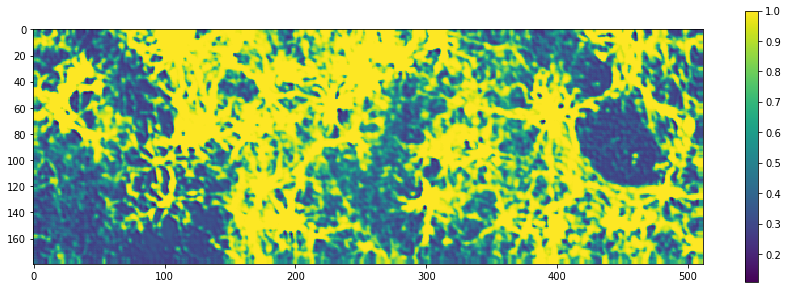

In [86]:
fig, ax = new_fig()
im = ax.imshow(loss_dict['alpha_fg_xy'].detach().cpu().numpy().T)
plt.colorbar(im)

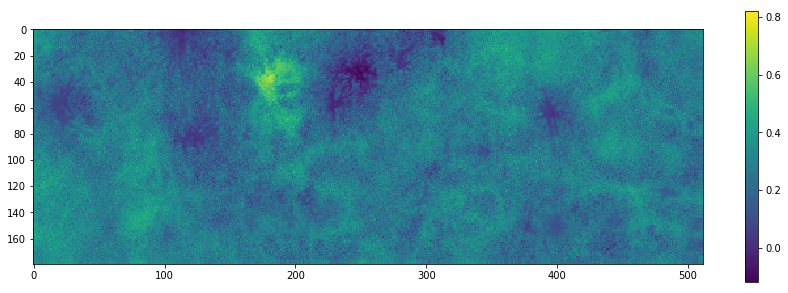

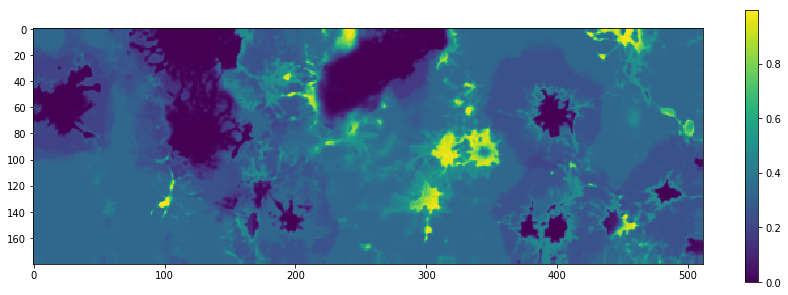

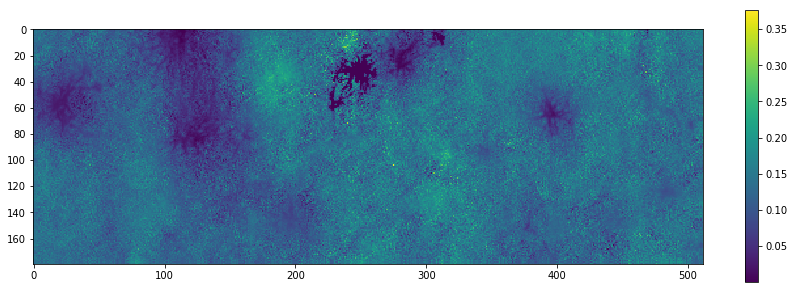

In [102]:
idx = 19
fig, ax = new_fig()
im = ax.imshow(loss_dict['chi_mxy'][idx, :, :].detach().cpu().numpy().T)
plt.colorbar(im)

fig, ax = new_fig()
im = ax.imshow(loss_dict['omega_mxy'][idx, :, :].detach().cpu().numpy().T)
plt.colorbar(im)

fig, ax = new_fig()
im = ax.imshow(loss_dict['omega_inducing_mxy'][idx, :, :].detach().cpu().numpy().T)
plt.colorbar(im)

In [100]:
logit_alpha_tau_m

Parameter containing:
tensor([ 0.0081,  0.0743,  0.0274,  0.0557,  0.0303, -0.0155,  0.0407,  0.0080,
         0.0379,  0.0518, -0.0798, -0.0127,  0.0060,  0.0666,  0.0323, -0.0281,
        -0.0178, -0.0013,  0.0140,  0.0616], device='cuda:0',
       requires_grad=True)

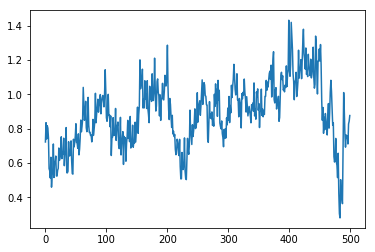

In [101]:
plt.plot(tau_mt[19, :].detach().cpu().numpy())

## Exploration